In [10]:
import string

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from unidecode import unidecode

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\German
[nltk_data]     Castro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
dialogs = pd.read_csv(r"C:\Users\German Castro\ml-repo\data\dialogos.csv",index_col=0)
dialogs['speaker'] = np.where(dialogs['speaker']=='amlo', 'politico','medico')
dialogs

,speaker,dialog,length
0,politico,"Amigas, amigos, paisanas, paisanos de Palenque:",47
1,politico,Me da mucho gusto estar de nuevo en trabajos d...,91
2,politico,"Antes de entrar en materia, quiero enviar un s...",471
3,politico,Di la instrucción de que se mantengan trabajan...,338
4,politico,"Quiero decirles a mis paisanos que padecen, qu...",113
...,...,...,...
155502,politico,¡Que viva Francisco I. Madero!,30
155503,politico,¡Que viva Venustiano Carranza!,30
155504,politico,¡Viva México!,13
155505,politico,¡Viva México!,13


## buscar desarrollar una clasificacion binary que vamos a tratar de identificar entre dos valores

## metrica de eleccion: Accuracy

# distribucion de las etiquetas

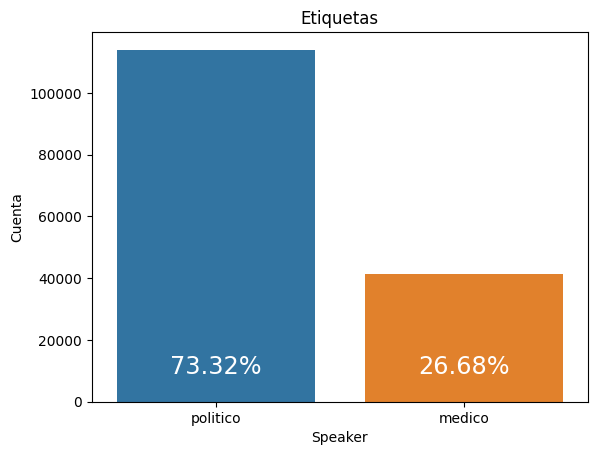

In [15]:
fig = plt.figure(dpi=100)
ax = fig.gca()
sns.countplot(x='speaker', data=dialogs, ax=ax)
ax.set_title("Etiquetas")
ax.set_xlabel("Speaker")
ax.set_ylabel("Cuenta")

percentages = (dialogs["speaker"].value_counts() / len(dialogs)).to_dict()
xs = {label.get_text():idx for idx, label in enumerate(ax.get_xticklabels())}
for label, pct in percentages.items():
#    x = labels[label].get_x()
    ax.text(xs[label],9000, f"{pct:0.2%}", ha='center', fontsize="xx-large", c="white")
    pass

# longitud del texto 

In [18]:
lengths = dialogs["dialog"].str.len()

dialog_lenghts = pd.DataFrame({
    "speaker": dialogs["speaker"],
    "length": lengths
})

<Axes: xlabel='length', ylabel='speaker'>

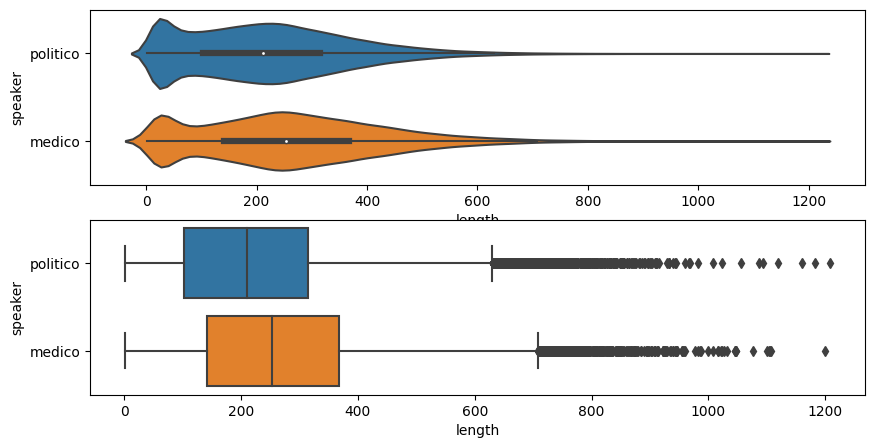

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, dpi=100, figsize=(10,5))

sns.violinplot(y="speaker" , x="length", data=dialog_lenghts, ax=ax1)
sns.boxplot(y="speaker" , x="length", data=dialog_lenghts, ax=ax2)

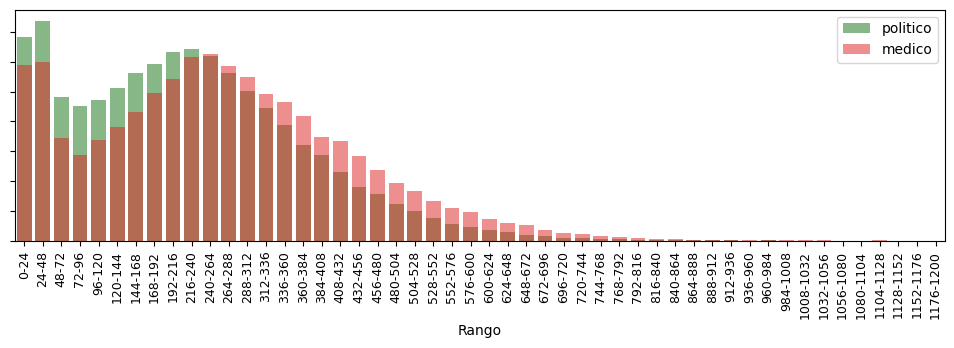

In [20]:
fig = plt.figure(dpi=100, figsize=(12, 3))
ax = fig.gca()


for label, color in [("politico", "green"), ("medico", "red")]:
    lengths = dialog_lenghts[dialog_lenghts["speaker"] == label]
    values, bins = np.histogram(lengths["length"], range=(0, 1200), bins=50)
    y = (bins[1:] + bins[:-1]) / 2
    sns.barplot(x=y, y=values/ len(lengths), label=label, color= color, ax=ax, alpha=0.5 )
ax.set_xticklabels([f"{int(_y)}-{int(_x)}" for _x,_y in zip(bins[1:], bins[:-1])], rotation=90, fontsize=9)
ax.set_yticklabels([])
ax.set_xlabel("Rango")
ax.legend()

# para dividir el dataset 

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
rest, test = train_test_split(dialogs, test_size=0.2, stratify=dialogs["speaker"])
train, val = train_test_split(rest, test_size=0.2, stratify=rest["speaker"])
len(train), len(val), len(test)

(99524, 24881, 31102)

# crear variables por segmentos  de la data 

In [24]:
dialogs_train = train["dialog"]
dialogs_val = val["dialog"]
dialogs_test = test["dialog"]

target_train = train["speaker"]
target_val = val["speaker"]
target_test = test["speaker"]

## luego hay que realizar feature engineering (transformar datos tipo string o tipo texto en un modelo numerico) para que el pueda ser entendido por el modelo de ML

### etiquetas

In [25]:
train_y = np.where(target_train == "politico", 1, 0)
val_y = np.where(target_val == "politico", 1, 0)
test_y = np.where(target_test == "politico", 1, 0)

In [26]:
dialogs_train.sample(10, random_state=132).values

array(['Es oportuno recordar que el año pasado México fue miembro del Consejo de Seguridad de Naciones Unidas con 187 votos a favor, la aprobación mayoritaria más alta de la historia.',
       'Muchas gracias, subsecretaria Natalia Toledo; muchas gracias, Homero Fernández, director de la Unidad Cultural Los Pinos; gracias, doctor Alomía.',
       'Esto, por ejemplo, se manifiesta cuando en una zona empieza a existir un brote de origen, otro brote de origen, y de repente hay una interconexión entre los propios brotes, en un municipio, en otro municipio y finalmente ya no se puede distinguir cuál es el municipio que aporta los casos porque existen personas que cambian de lugar a lo largo del día entre un sitio y otro, y están vinculadas por cadenas de transmisión.',
       'Aquí lo importante es destacar que ofrecimos que íbamos a vacunar a los adultos mayores aun con una dosis y cumplimos instalando centros de vacunación en todos los municipios del país, hasta en los municipios más apar

In [27]:
example_sentence = dialogs_train.iloc[80567]
print(example_sentence)

Hoy tuvimos ocho mil 279 aplicaciones de vacuna en la parte del programa general. Recordar que el programa general de vacunación contra COVID-19 o contra el virus SARS-CoV-2, que produce COVID-19 tiene cinco etapas claramente definidas:


# tokenizacion del example

In [28]:
from nltk.tokenize.toktok import ToktokTokenizer

tk_tokenizer = ToktokTokenizer()

In [29]:
tokens = tk_tokenizer.tokenize(example_sentence)
print(" # ".join(tokens))

Hoy # tuvimos # ocho # mil # 279 # aplicaciones # de # vacuna # en # la # parte # del # programa # general. # Recordar # que # el # programa # general # de # vacunación # contra # COVID-19 # o # contra # el # virus # SARS-CoV-2 # , # que # produce # COVID-19 # tiene # cinco # etapas # claramente # definidas # :


## crear funcion que  permita limpiar la sentence  de elementos de uso comun que no definan la calsificacion de la etiqueta como signos de puntuacion stopswords del spanish, tildes y tokenizarla

In [30]:
sp_stopwords = stopwords.words("spanish")
sp_punctuation = string.punctuation + '¿¡'

not_wanted = set((unidecode(word) for word in sp_stopwords)) | set(sp_punctuation)

tk_tokenizer = ToktokTokenizer()


def tokenize(sentence):
    clean = []
    clean_sentence = unidecode(sentence)
    for token_ in tk_tokenizer.tokenize(clean_sentence):
        token = token_.lower()
        if token in not_wanted:
            continue
        clean.append(token)
    return clean

In [31]:
tokens = tokenize(example_sentence)
print(example_sentence)
print()
tokens = tokenize(example_sentence)
print(" # ".join(tokens))

Hoy tuvimos ocho mil 279 aplicaciones de vacuna en la parte del programa general. Recordar que el programa general de vacunación contra COVID-19 o contra el virus SARS-CoV-2, que produce COVID-19 tiene cinco etapas claramente definidas:

hoy # ocho # mil # 279 # aplicaciones # vacuna # parte # programa # general. # recordar # programa # general # vacunacion # covid-19 # virus # sars-cov-2 # produce # covid-19 # cinco # etapas # claramente # definidas


## vectorizacion

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizador_ejemplo = CountVectorizer(binary=True, analyzer=tokenize, max_features=4000)

In [34]:
ejemplos = [
    "viva mexico paisanos en setpiembre",
    "en mexico hay inundaciones de viva voz"
]
vectors = vectorizador_ejemplo.fit_transform(ejemplos)

vocabulary = vectorizador_ejemplo.vocabulary_
columns = [token for token, _ in sorted(vocabulary.items(), key=lambda item: item[1])]
pd.DataFrame(vectors.todense(), columns=columns, index=[1, 2])

,inundaciones,mexico,paisanos,setpiembre,viva,voz
1,0,1,1,1,1,0
2,1,1,0,0,1,1


In [35]:
vectorizador_real = CountVectorizer(binary=True, analyzer=tokenize, max_features=1000)

## entrenar modelo 

In [37]:
vectorizador_real.fit(dialogs_train)

train_x = vectorizador_real.transform(dialogs_train)
val_x = vectorizador_real.transform(dialogs_val)
test_x = vectorizador_real.transform(dialogs_test)

# modelo de regresion logistica

In [38]:
from sklearn.linear_model import LogisticRegression

In [39]:
lr = LogisticRegression(max_iter=1000, class_weight="balanced")

In [40]:
lr.fit(train_x, train_y)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [42]:
train_pred = lr.predict(train_x)  # Para diagnosticar overfitting
train_pred

array([1, 1, 1, ..., 1, 1, 0])

In [43]:
val_pred = lr.predict(val_x)  # Para decidir cambios sobre el modelo
val_pred

array([1, 1, 1, ..., 1, 1, 1])

## revisar metrica accuracy

In [45]:
from sklearn.metrics import accuracy_score

In [46]:
training_accuracy = accuracy_score(train_y, train_pred)
validation_accuracy = accuracy_score(val_y, val_pred)

print(f"Training accuracy:   {training_accuracy:0.2%}")
print(f"Validation accuracy: {validation_accuracy:0.2%}")

Training accuracy:   92.99%
Validation accuracy: 92.69%


## evaluacion de oracion propia 

In [47]:
oración = "Quedate en casa, la curva epidémica no se ha reducido"
own_x = vectorizador_real.transform([oración])
result = lr.predict(own_x)
medico, politico = lr.predict_proba(own_x).squeeze() * 100
print(f"{medico:05.2f}% – Médico\n{politico:05.2f} - Político")

98.88% – Médico
01.12 - Político
